Data Downloaded from : https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats?select=Team+Summaries.csv

Challenges Faced During the Project:
Data Quality and Inconsistencies:

Challenge: The dataset contained inconsistent data formats, special characters, and errors such as duplicate entries, making it difficult to clean and preprocess accurately.<br>
Solution: Implemented rigorous data cleaning steps, such as using regular expressions to standardize team names, removing special characters, correcting inconsistencies in naming, and handling duplicates efficiently

Challenge: Historically, there were two associations National Basketball Association(NBA) and the American Basketball Association(ABA). Several teams before 1971 which were part of ABA are not defunct or have changed their names. In some cases two teams have merged. Even post 1971 teams have
have changed their names as part of branding strategy. All this makes it difficult to correctly track the lineage of the team so that we can check for the facts across time. <br>
Solution: Represented all the predecessor of a team as a graph network and applied depth first search to collate all the data corresponding to the present day team. Aggregated the data and presented it in a consistent format suitable for analysis

Challenge: When joining player data with team data we used the an abbreviated names column. However several teams has multiple abbreviations which made joining inconsistent<br>
Solution: Used unique abbreviation to map to team names and corrected isolated cases if the join was improper.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro

team_summary = pd.read_csv("Team Summaries.csv")

### Key Steps to Select Variables:

1. Exclude Outcome-Driven Metrics: Metrics that directly depend on wins (e.g., playoffs, pts_per_game, opp_pts_per_game) should generally not be included as predictors to avoid leakage.

2. Check Multicollinearity: Avoid using multiple highly correlated variables (e.g., fg_percent and ts_percent are usually strongly correlated).

3. Include Metrics Related to Performance and Efficiency : Choose variables reflecting team efficiency (offensive and defensive ratings) and playstyle (e.g., pace).

4. Test Relationships with Wins: Use correlation analysis (e.g., Pearson correlation or VIF) to identify the best predictors.

The variables (f_tr, x3p_ar, ts_percent, e_fg_percent, tov_percent, orb_percent, ft_fga, opp_e_fg_percent, opp_drb_percent, opp_ft_fga, arena, attend, attend) were excluded from the model for the following reasons:

1. Multicollinearity:
Some of these variables are highly correlated with others, which can lead to multicollinearity. Multicollinearity occurs when predictor variables are correlated, making it difficult to isolate the individual effects of each predictor on the outcome.
For example, ts_percent (True Shooting Percentage) is highly related to e_fg_percent (Effective Field Goal Percentage) and f_tr (Free Throw Rate). Including them all together would lead to redundancy in information provided to the model.

2. Predictive Power:
The goal was to include variables that have the most direct influence on the prediction of wins. adj_n_rtg already captures much of the offensive and defensive efficiency, including many of the metrics provided by ts_percent, e_fg_percent, and f_tr.
Variables like opp_drb_percent and opp_ft_fga may overlap with other defensive efficiency metrics already included in the model like opp_e_fg_percent and opp_tov_percent.

3. Irrelevance to Outcome:
Variables like arena and attend were excluded because they do not have a direct, measurable impact on the performance of a team in terms of wins and losses in a season. While attendance could theoretically influence player morale or pressure, it's a less direct influence compared to team statistics like adj_n_rtg or pace.

4. Complexity:
Adding too many variables increases model complexity without necessarily improving predictive accuracy. Including all available variables would lead to overfitting, where the model becomes too specific to the training data and performs poorly on new data.
The chosen variables (adj_n_rtg, pace, ts_percent, orb_percent, opp_e_fg_percent, opp_tov_percent) were selected for their direct relevance and measurable influence on team wins and losses.
In summary, the excluded variables were either redundant, did not add predictive power to the model, or their inclusion would have led to multicollinearity issues, thus complicating the model without providing additional useful information.

To ensure the model captures meaningful relationships without unnecessary complexity, we added derived or complementary variables only if they provide significant additional explanatory power.

Additions:
Win Percentage (win_percent):

Formula: win_percent = w /(w + l)
Rationale: This metric normalizes wins relative to the total number of games played and could add context to absolute win counts.

Adjusted Net Rating (adj_n_rtg):
Formula: n_rtg * sos
Rationale: Adjusting net rating by the strength of schedule (sos) could provide insight into how much a team’s performance is influenced by the quality of its opponents.

normalizing the data is a good practice, especially when using regression models. Normalization scales all predictors to a similar range, improving model stability and interpretability, particularly when predictors are on different scales.

### Predicted Variable and Model Selection

The distribution of the outcome variable (wins) looks approximately Gaussian, it is appropriate to use a linear regression model rather than a Poisson regression model. Poisson regression is typically used when the outcome variable is a count that follows a Poisson distribution, which is positively skewed, not Gaussian.

Choosing between win (total number of wins) and win_percent (win percentage) as the outcome variable depends on the specific context and the goals of the model:

1. win (Total Wins):
Direct Measure: win directly represents the number of games a team won in a season. It is a straightforward, absolute measure of a team's success.<br>
Interpretability: The interpretation of coefficients in the model is simpler because each unit increase in predictors directly corresponds to a change in the number of wins.<br>
Limitations: The model may be influenced more heavily by teams with many games (larger sample size), which could skew results if a team with 82 games played and 60 wins is compared directly with a team with 41 games played and 30 wins.

2. win_percent (Win Percentage):
Normalized Measure: win_percent normalizes the performance by the total games played, providing a percentage of wins relative to total games. This can be useful when comparing teams with different numbers of games played.<br>
Comparative Advantage: win_percent is especially useful when comparing teams with varying schedules, as it allows for a fairer comparison of performance across teams.<br>
Interpretability: The coefficients become less interpretable in a traditional sense because a change in predictors does not correspond directly to a specific number of wins but rather a change in the win percentage.

Choosing Between win and win_percent:

Our primary goal was to compare teams with different numbers of games played or if the data set includes teams with significantly different schedules rather than to predict the exact number of wins a team will achieve in a season and you are interested in the magnitude of each predictor's impact on the win count

To prevent teams with more games from overly dominating the model due to larger sample sizes. we choose win percentage. In many practical cases, win_percent is preferred because it is a relative measure, making it more robust when comparing teams across different schedules.

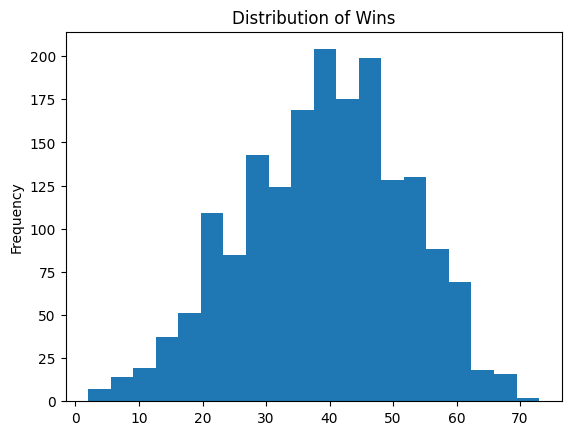

In [2]:
team_summary.w.plot.hist(bins=20, title='Distribution of Wins');

In [3]:

predictors = "adj_n_rtg, pace, ts_percent, orb_percent, opp_e_fg_percent, opp_tov_percent".split(', ')

scaler = StandardScaler()

team_summary['win_percent'] = team_summary['w'] / (team_summary['w'] + team_summary['l'])
team_summary['adj_n_rtg'] = (team_summary['d_rtg'] - team_summary['o_rtg']) * team_summary['sos']
team_summary['opp_tov_percent'] = team_summary['opp_tov_percent'] / 100
team_summary['orb_percent'] = team_summary['orb_percent'] / 100
team_summary[['adj_n_rtg', 'pace']] = scaler.fit_transform(team_summary[['adj_n_rtg', 'pace']])


In [4]:
target = 'win_percent'

# Filter dataset to include only the relevant columns
data = team_summary[predictors + [target]].dropna()

# Split the data into training and testing sets
X = data[predictors]
X['intercept'] = 1
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1984)
model = sm.OLS(y_train, X_train).fit()


print(model.summary())

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Intercept is removed for the next model which are non-linear and do not required intercept
X_test.drop('intercept', axis=1, inplace=True)
X_train.drop('intercept', axis=1, inplace=True)


                            OLS Regression Results                            
Dep. Variable:            win_percent   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     503.5
Date:                Thu, 12 Dec 2024   Prob (F-statistic):          4.05e-318
Time:                        14:04:56   Log-Likelihood:                 1310.9
No. Observations:                1162   AIC:                            -2608.
Df Residuals:                    1155   BIC:                            -2572.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
adj_n_rtg           -0.0045      0.002  

### Checking Assumption
1) Homoskedasticity : Residuals have constant variance across all levels of the fitted values.
2) Linearity : The relationship between predictors and the response variable is linear.
3) Normality of Residuals : Residuals are normally distributed.
4) Independence of Residuals : Residuals are independent of each other (no autocorrelation).
5) Multicollinearity : Predictors are not highly correlated with each other.
6) Outlier : There are no significant outliers in the predictors


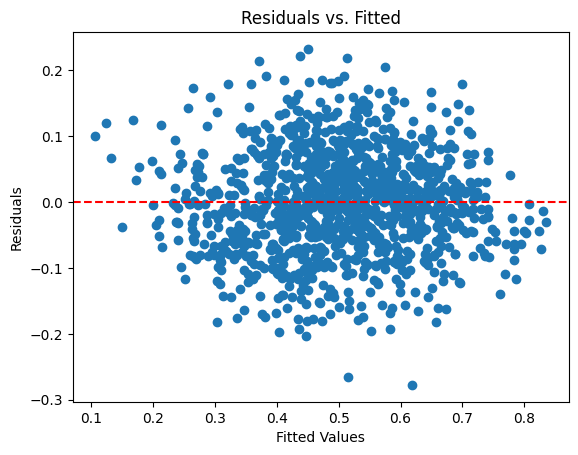

In [5]:

# Residuals vs. Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
plt.scatter(fitted_vals, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# the random distribution of residuals suggests homoskedasticity and linearity


1) Partial residual plots help assess the relationship between each predictor and the outcome variable while accounting for the presence of other predictors in the model. 
2) These plots are useful to check if the linearity assumption holds for each predictor.

### How to Interpret
1. Linear Relationship: A clear linear trend in the partial residual plot indicates that the relationship between the predictor and the outcome variable is approximately linear.
2. Non-linearity: Curves or patterns in the plot may suggest the need for a transformation (e.g., log, square root) or adding polynomial terms.
3. Outliers or Leverage Points: Points that deviate significantly from the trend may indicate outliers or leverage points.

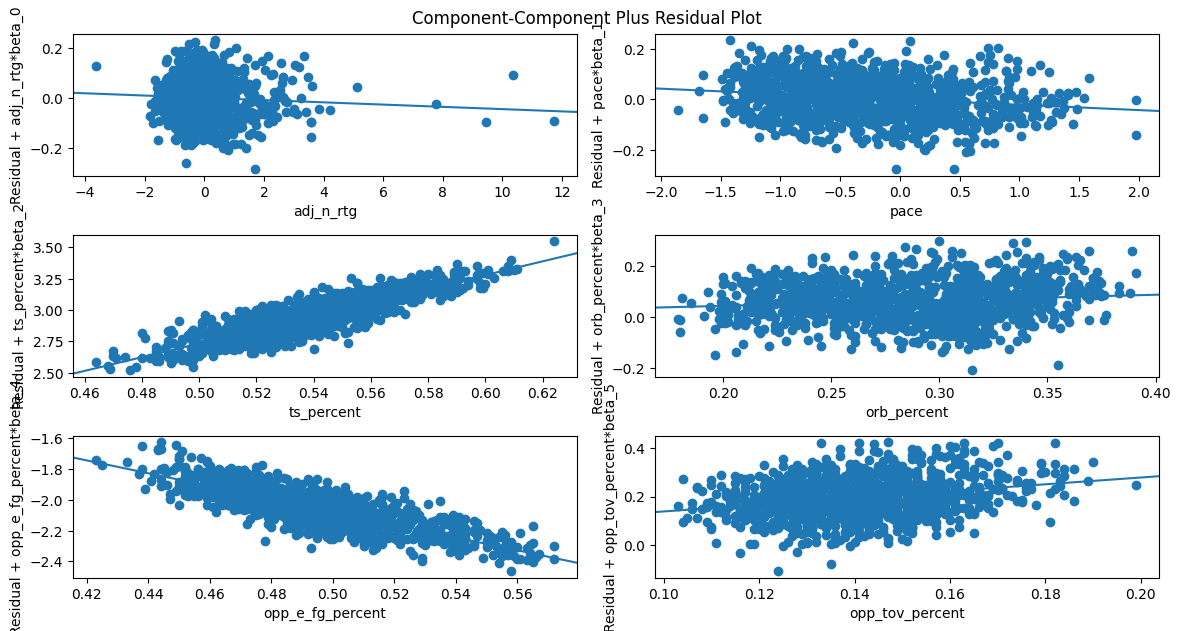

In [6]:

fig = plt.figure(figsize=(12, 8))  
sm.graphics.plot_ccpr_grid(model, fig=fig)  
plt.show()

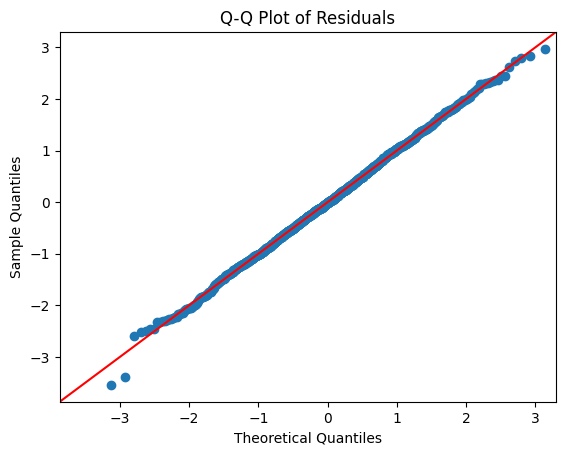

In [7]:
# Q-Q Plot
normalized_residuals = (residuals - residuals.mean()) / residuals.std() 
sm.qqplot(normalized_residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()


The Shapiro-Wilk Test is used to test the null hypothesis that the data follows a normal distribution. The test statistic and the associated p-value are used to determine the normality of the data.

#### Interpretation:
* Statistic = 0.99908: This value is very close to 1. A Shapiro-Wilk test statistic close to 1 suggests that the data is normally distributed.
* p-value = 0.84366: The p-value represents the probability that the observed test statistic would occur if the null hypothesis were true (i.e., the data follows a normal distribution). A high p-value (greater than the common alpha level of 0.05) indicates a failure to reject the null hypothesis.

Conclusion: Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This suggests that the residuals from the model are normally distributed, which is a good indication for the linear regression model’s assumptions being met. Therefore, the model's residuals appear to be normally distributed, validating one of the key assumptions of linear regression.

In [8]:
# Shapiro-Wilk Test

stat, p = shapiro(normalized_residuals)
print(f'Shapiro-Wilk Test: Statistic={stat}, p={p}')

Shapiro-Wilk Test: Statistic=0.9990779161453247, p=0.8436605930328369


The Durbin-Watson Test is used to detect autocorrelation in the residuals of a regression model. It tests the null hypothesis that there is no autocorrelation (i.e., the residuals are independent) against the alternative hypothesis that there is positive autocorrelation.

#### Interpretation of the Durbin-Watson Test:
1. Test Statistic = 2.02034: The value ranges from 0 to 4, with a value of 2 indicating no autocorrelation.
2. Interpreting the value:
    * A value close to 2 suggests that there is no autocorrelation in the residuals.
    * A value significantly less than 2 suggests positive autocorrelation (residuals are not independent).
    * A value significantly greater than 2 suggests negative autocorrelation.

Conclusion:
The result is very close to 2, suggesting that the residuals do not show significant autocorrelation.
Therefore, the assumption of independence of residuals holds for this model, which is a positive indicator of the model's validity.

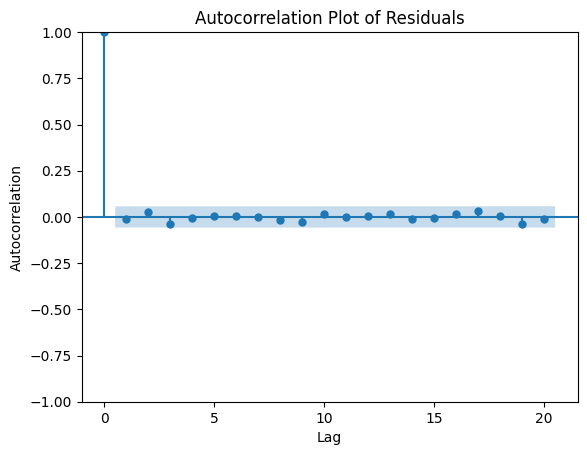

Durbin-Watson Test: 2.020340742406368


In [9]:
# Generate autocorrelation plot
plot_acf(residuals, lags=20)
plt.title("Autocorrelation Plot of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


dw = durbin_watson(residuals)
print(f'Durbin-Watson Test: {dw}')


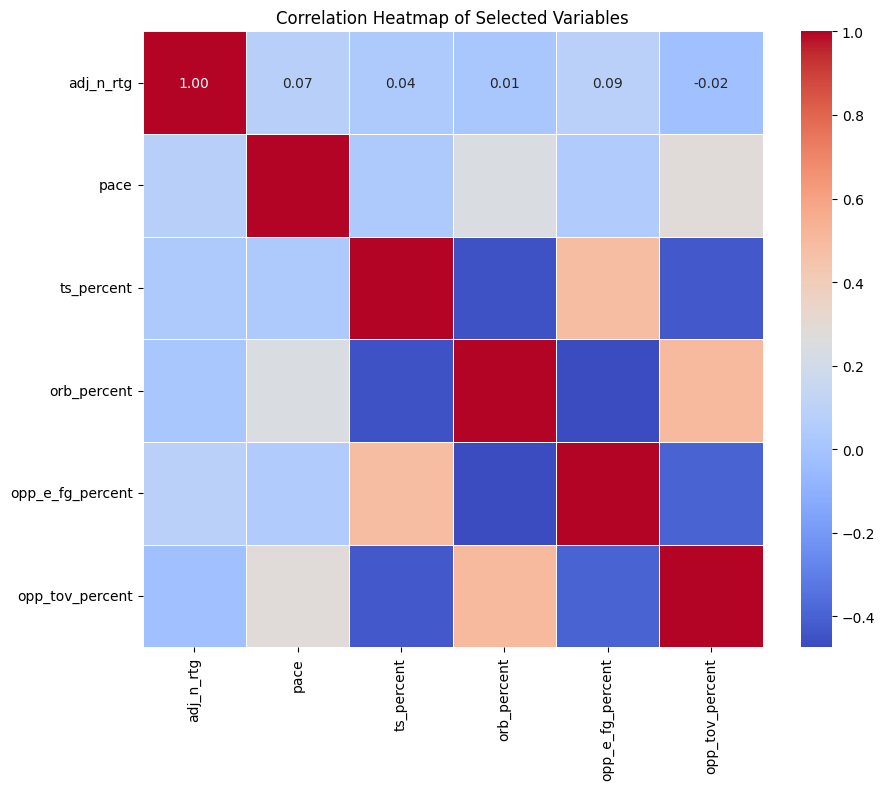

In [10]:
# Dropping rows with missing values in the selected columns to ensure accurate analysis
df_clean = team_summary[predictors].dropna()

# Calculate the correlation matrix
correlation_matrix = df_clean.corr()

# Plotting the heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Variables")
plt.show()

The Variance Inflation Factor (VIF) test measures the multicollinearity in a regression model by quantifying how much the variance of a regression coefficient increases due to collinearity with other predictors.

Interpretation of VIF Values:
1. VIF ≤ 5: Indicates little or no multicollinearity. This is generally acceptable.
2. 5 < VIF ≤ 10: Moderate multicollinearity. It's still manageable but may lead to unreliable estimates.
3. VIF > 10: Indicates high multicollinearity, which could cause issues with model stability and prediction accuracy.

For our model all the variables do not show no multi-collinearity

In [11]:
# Calculating VIF to check for multicollinearity
X = add_constant(df_clean)  # Adding a constant for VIF calculation
vif_data = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif_data[1:]

,Variable,VIF
1,adj_n_rtg,1.015073
2,pace,1.209165
3,ts_percent,1.538387
4,orb_percent,1.663760
5,opp_e_fg_percent,1.555921
6,opp_tov_percent,1.574269


### Cook's Distance
Cook's distance measures the influence of each data point on the regression results. A large Cook's distance value suggests that a particular observation has a high influence on the regression.

### Leverage
Leverage measures how far an observation’s values of the independent variables are from their means. High-leverage points are those that have extreme predictor values and may disproportionately affect the regression model.

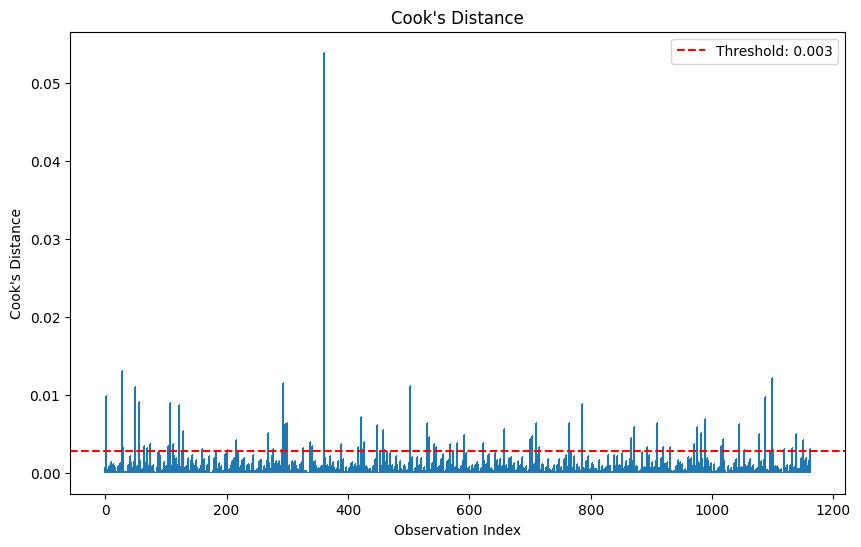

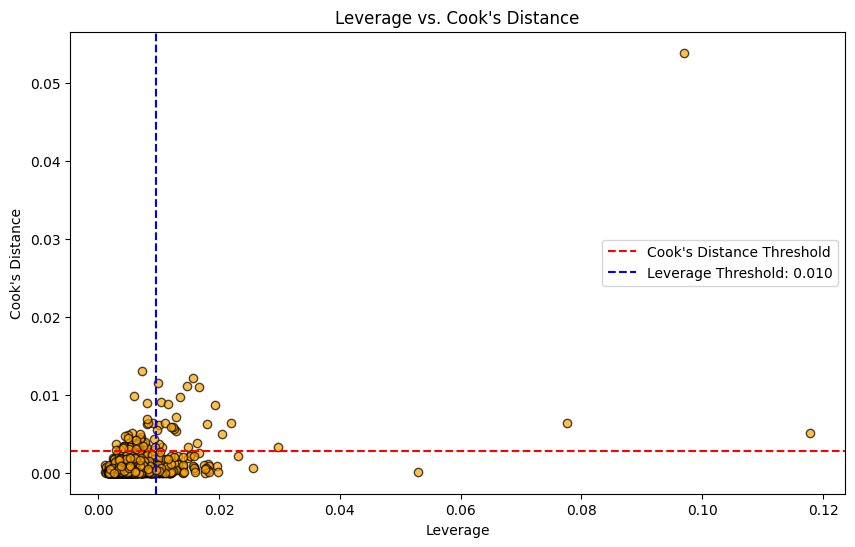

In [12]:
# Cook's Distance
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

# Leverage values
leverage = influence.hat_matrix_diag

# Thresholds
n = len(y)  # Number of observations
p = model.df_model + 1  # Number of predictors (including intercept)
threshold_cooks = 4 / n  # Common threshold for Cook's distance

# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(y=threshold_cooks, color="r", linestyle="--", label=f"Threshold: {threshold_cooks:.3f}")
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Leverage Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage, cooks_d, edgecolors="k", c="orange", alpha=0.7)
plt.axhline(y=threshold_cooks, color="r", linestyle="--", label=f"Cook's Distance Threshold")
plt.axvline(x=2 * p / n, color="b", linestyle="--", label=f"Leverage Threshold: {2*p/n:.3f}")
plt.xlabel("Leverage")
plt.ylabel("Cook's Distance")
plt.title("Leverage vs. Cook's Distance")
plt.legend()
plt.show()


1. Identify the Influential Points

In [13]:
# Identify influential points
influential_points = np.where(cooks_d > threshold_cooks)[0]

# Print indices of influential points
print(f"Influential Points: {influential_points}")

Influential Points: [   1   27   29   49   55   64   68   73  104  106  111  121  128  160
  200  215  269  277  292  293  297  299  326  338  340  360  389  417
  422  424  426  447  457  460  502  530  533  541  545  568  573  580
  591  622  657  700  704  710  715  764  786  866  872  892  909  919
  930  970  975  981  988 1014 1018 1044 1052 1077 1087 1099 1100 1118
 1131 1139 1150 1161]


### Non-Linear Monsters : Ensemble Average and Friends

In [14]:
# Initialize and train the XGBoost regressor
model = XGBRegressor(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=3,           # Maximum tree depth
    random_state=1984        # Seed for reproducibility
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error: 0.005
R² Score: 0.789


In [15]:
model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Maximum depth of each tree
    random_state=1984,        # Seed for reproducibility
    n_jobs=-1               # Use all available CPU cores
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error: 0.006
R² Score: 0.772


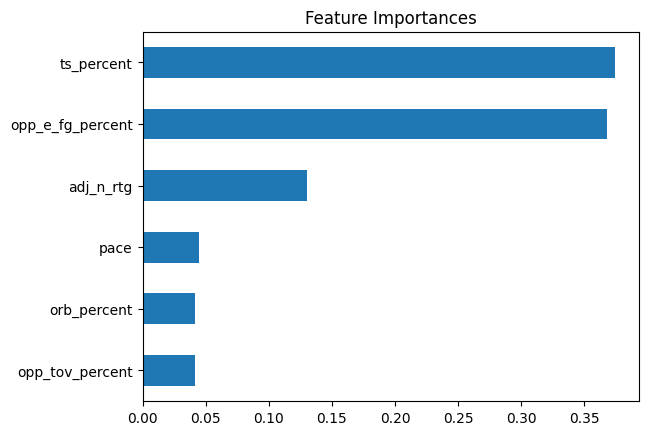

In [16]:
import matplotlib.pyplot as plt
feature_importances = pd.Series(model.feature_importances_, index=predictors)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()